<a id='clf_top'>

# Classify pictures from auction lots

The auction lots are accompanied with pictures. This notebook performs classification analyses.

## Classification models
1. [Simple binary classification model](#clf_model_1)
2. [Random forest](#clf_model_2)
3. [Multiclass](#clf_model_3)

## Results
1. [Model performance](#clf_performance)
    1. [Confusion matrix](#clf_performance_confmtx)  
    Models can miss or falsly identify items. Performance can be summarized in a confusion matrix:
    
    |      | predicted |     |
    |-----:|-----------|-----|
    | **real** | TP        | FP  |
    |      | FN        | TN  |  
    
    Correct: **TP**: True positive, **TN**: True negative  
    Wrong: **FN**: False negative, **FP**: False positive
    
    2. [ROC](#clf_performance_roc)  
    Receiver operator curve
    

In [1]:
import sys
import os
import re
import json

In [2]:
with open('../assets/drz-settings-current.json', 'r') as fid:
    cfg = json.load(fid)
print(cfg['AUCTION'])
    
OPBOD = cfg['AUCTION']['kind'] == 'opbod'
AUCTION_ID = cfg['AUCTION']['id']
DATA_DIR = cfg['FILE_LOCATION']['data_dir']
RESULTS_DIR = cfg['FILE_LOCATION']['report_dir']
IMAGES_DIR = cfg['FILE_LOCATION']['image_dir']
VERBOSE = int(cfg['GENERAL']['verbose'])
SAVE_METHOD = cfg['GENERAL']['save_method']


{'kind': 'inschrijving', 'id': '2025-0010', 'date': '20250524'}


In [3]:
if SAVE_METHOD == 'skip_when_exist':
    do_save = lambda fn: not(os.path.isfile(fn))
elif SAVE_METHOD == 'always_overwrite':
    do_save = lambda _: True
elif SAVE_METHOD == 'skip_save':
    do_save = lambda _: False
else:
    raise NotImplementedError(f'SAVE_METHOD: {SAVE_METHOD} not implemented')

In [4]:
TAG_SINGLE = "nbconvert_instruction:remove_single_output"
SKIP_MASK = True

In [5]:
USE_HIGH_RES = True # Do not reshape image to smaller size. This is beta! Memory issues may occur
PREDICT_CLASS = 'AUDI' # Test classifier on this class (brand)
SUB_SELECTION = None#'noclassic'#None#'citybug' 

In [6]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re

import seaborn as sns
from PIL import Image

from os.path import isfile


In [7]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use([
    'default',
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/movshon.mplstyle",
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-notebook.mplstyle"
])

In [8]:
# file name pattern for images
def image_file(lot, idx, rootdir = IMAGES_DIR):

    # subdir per month
    # if lot.startswith('2022-'):
    #    return r'/home/tom/data/satdatsci-images/{:s}/{:s}/{:s}-{:02.0f}.jpg'.format(lot[:4], lot[5:7], lot, idx)


    # return r'/home/tom/data/satdatsci-images/{:s}/{:s}-{:02.0f}.jpg'.format(lot[:4], lot, idx)
    lot__ = lot.split('-')
    #HACK ALERT!
    # if there are two auction a month
    if lot.startswith('2021-06-'):
        lot_ = lot.split('-')
        lot = '{}-{}-{}'.format(lot_[0], lot_[2][-2:], lot_[2][:-2])
    
    if len(lot__[2]) == 4:
        return r'{:s}/{:s}/{:02.0f}/{:s}-{:02.0f}.jpg'.format(rootdir, lot__[0], int(lot__[1]), lot, idx)
    
    # lot name has 6 characters, and has suffix
    lot__ += [lot__[2][-2:]]
    lot__[2] = lot__[2][:4]
    return f'{rootdir}/{lot__[0]}/{int(lot__[3]):02.0f}/{lot__[0]}-{lot__[3]}-{lot__[2]}-{idx:02.0f}.jpg'
    
    

# lot number to date
def idx2date(idx):
    M = re.match('([0-9]{4}-[0-9]{1,2})-[0-9]{4}', idx)
    return pd.to_datetime(M[1], format='%Y-%m')

# Load data

In [9]:
if OPBOD:
    fn = f'{DATA_DIR}/cars-for-imageclf-opbod.pkl'
    image_dir = '/home/tom/data/satdatsci-images/opbod'
else:
    fn = f'{DATA_DIR}/cars-for-imageclf.pkl'
    image_dir = '/home/tom/data/satdatsci-images'

print(fn)
df = pd.read_pickle(fn)
print(df.shape)

/home/tom/bin/satdatsci/Saturday-Datascience/data/cars-for-imageclf.pkl
(13174, 16)


In [10]:
# add date
df.loc[:,'auction_date'] = df.reset_index()['index'].apply(idx2date).values

# drop obs with no images stored
if not OPBOD:
    df.drop(index = df[df.auction_date < pd.to_datetime('2018-12-01')].index, inplace=True) # also drop 2018-11 (11 cars)

# file location to front view pictures
df.loc[:,'front_image'] = df.reset_index().loc[:,'index'].apply(lambda l:image_file(l,0,image_dir)).values
    
# fix filenames. Image name is different from index
multiplier = [int(k.split('-')[2][-2:]) if len(k)==4+2+6+2 else 0 for k in df.index]
auct_month = np.array([[int(k.split('-')[0]), int(k.split('-')[1])] for k in df.index])
auct_month = np.insert(auct_month, 2, multiplier, axis=1) # append multiplier

# if not OPBOD:
#     # select first auction of month as of 2021/07
#     # index: 2021-07-llll07
#     # wrong file: <path>2021-07-llll07-ii ii: image counter
#     # correct file: <path>2021-07-llll-ii

#     sel = \
#     ((auct_month[:,0] == 2021) & (auct_month[:,1] >= 7)) |\
#     (auct_month[:,0] >= 2022)

#     # Month can be lobbed off from filename
#     df.loc[sel,'front_image'] = df.loc[sel,'front_image'].apply(lambda x: re.sub(r'(\d{2})-([0-9]{2}\.jpg)$', r'-\g<2>', x))

# # select second auction of month as of 07 in 2021 and multiplier is 10
# # index: 2021-07-llll17
# # wrong file: <path>2021-07-llll17-ii
# # correct file: <path>2021-17-llll-ii
# # Note that auction 2021-16 has the correct filenames in the dataframe

# sel = \
# ((auct_month[:,0] == 2021) & (auct_month[:,1] >= 7)) &\
# (auct_month[:,1] - auct_month[:,2] == -10)

# # Multiplier moves to front
# df.loc[sel,'front_image'] = df.loc[sel,'front_image'].apply(lambda x: re.sub(r'(0[1-9]|1[0-2])-([0-9]{4})([0-9]{2})-([0-9]{2}\.jpg)$', r'\g<3>-\g<2>-\g<4>', x))

# # select second auction of month as of 2022 and multiplier is 20
# # index: 2022-07-llll27
# # wrong file: <path>2022-07-llll27-ii
# # correct file: <path>2022-27-llll-ii
# sel = \
# (auct_month[:,0] == 2022) &\
# (auct_month[:,1] - auct_month[:,2] == -20)

# # Multiplier moves to front
# df.loc[sel,'front_image'] = df.loc[sel,'front_image'].apply(lambda x: re.sub(r'(0[1-9]|1[0-2])-([0-9]{4})([0-9]{2})-([0-9]{2}\.jpg)$', r'\g<3>-\g<2>-\g<4>', x)).values

# # Multiplier is in subdir and filename
# sel = \
# (auct_month[:,0] >= 2023) 
# fns = pd.Series(index=df.loc[sel].index, name='front_image', dtype=str)
# for ((ix, fn), v) in zip(df.loc[sel,'front_image'].iteritems(), auct_month[sel, 2]):
#     # print(ix, fn, v)
#     fns[ix] = re.sub('(/\d{4}/)\d{2}(/\d{4}\-)\d{2}(.+\.jpg)', f'\g<1>{v:02.0f}\g<2>{v:02.0f}\g<3>',fn)
# df.update(fns)
# print(fns[ix])

# fix front images ad hoc
if not OPBOD:
    # no front image
    df.drop(index='2019-7-2212', inplace=True)
    df.drop(index='2020-10-7232', inplace=True) # fiat
    
    # front image is not first
    df.loc['2019-9-9152','front_image'] = image_file('2019-9-9152',1)
    df.loc['2020-10-7235','front_image'] = image_file('2020-10-7235',1) # smart
    df.loc['2022-08-802528', 'front_image'] = image_dir + '/2022/28/2022-28-8025-01.jpg' # boxcar
    df.loc['2022-12-702112', 'front_image'] = image_dir + '/2022/12/2022-12-7021-11.jpg' # alto
    df.loc['2023-04-705907', 'front_image'] = image_dir + '/2023/07/2023-07-7059-01.jpg' # golf
    df.loc['2024-03-700205', 'front_image'] = image_dir + '/2024/05/2024-05-7002-11.jpg' # twingo
else:
    df.loc['2023-06-1053', 'front_image'] = image_dir + '/2023/06/2023-06-1053-13.jpg' # renault
    df.drop('2023-08-1101', inplace=True) # alfa, no front-left
    df.drop('2023-08-1214', inplace=True) # kangoo, no front-left
    df.drop('2023-08-1257', inplace=True) # spark, no front-left
    df.drop('2023-08-1291', inplace=True) # Merc, no front-left

# print result
print(df.shape)
display(df.tail(), metadata={'tags': (TAG_SINGLE, )})

(9538, 18)


,image_urls,brand,model,model_specification,color,age,body_type,convertible,number_of_doors,length,height,width,wheelbase,foreign_registration,registration_number,taxi,auction_date,front_image
2025-05-706810,[http://verkoop.domeinenrz.nl/ufc/static/17472...,LAND ROVER,range rover,NaN,ZWART,3814 days,Stationwagen,False,5.0,5265.0,1880.0,1980.0,3120.0,,S-463-TR,False,2025-05-01,/home/tom/data/satdatsci-images/2025/10/2025-1...
2025-05-706910,[http://verkoop.domeinenrz.nl/ufc/static/17472...,BMW,535d,NaN,ZWART,5011 days,Stationwagen,False,4.0,4907.0,1462.0,1860.0,2970.0,,GH-437-V,False,2025-05-01,/home/tom/data/satdatsci-images/2025/10/2025-1...
2025-05-707010,[http://verkoop.domeinenrz.nl/ufc/static/17472...,MERCEDES-BENZ,c 320 cdi,NaN,NaN,NaT,NaN,False,NaN,NaN,NaN,NaN,NaN,Bulgaars,,False,2025-05-01,/home/tom/data/satdatsci-images/2025/10/2025-1...
2025-05-707110,[http://verkoop.domeinenrz.nl/ufc/static/17472...,AUDI,rs 4 avant,NaN,ZWART,2093 days,Stationwagen,False,4.0,4883.0,1460.0,1870.0,2830.0,,L-655-DS,False,2025-05-01,/home/tom/data/satdatsci-images/2025/10/2025-1...
2025-05-707410,[http://verkoop.domeinenrz.nl/ufc/static/17472...,MERCEDES-BENZ,e300 cdi,NaN,NaN,NaT,NaN,False,NaN,NaN,NaN,NaN,NaN,Duits,,False,2025-05-01,/home/tom/data/satdatsci-images/2025/10/2025-1...


In [11]:
if SUB_SELECTION == 'citybug':
    df.loc[:, 'subsel'] = (
        (df.brand == 'PEUGEOT') & (df.model.str.contains('107')) |
        (df.brand == 'CITROËN') & (df.model.str.contains('c1')) |
        (df.brand == 'TOYOTA') & (df.model.str.contains('aygo'))
    )
elif SUB_SELECTION == 'newsmallfamily':
    df.loc[:, 'subsel'] = (
        (df.brand == 'VOLKSWAGEN') & (df.model.str.contains('up')) |
        (df.brand == 'SKODA') & (df.model.str.contains('citigo')) |
        (df.brand == 'SEAT') & (df.model.str.contains('mii'))
    )
elif SUB_SELECTION == 'A00':
    df.loc[:, 'subsel'] = (
        (df.brand == 'VOLKSWAGEN') & (df.model.str.contains('lupo')) |
        (df.brand == 'SEAT') & (df.model.str.contains('arosa'))
    )
elif SUB_SELECTION == 'onlyclassic':
    df.loc[:, 'subsel'] = df.age > pd.Timedelta(25*365.25,'d')
elif SUB_SELECTION == 'noclassic':
    df.loc[:, 'subsel'] = df.age < pd.Timedelta(20*365.25,'d')
    
if SUB_SELECTION is not None:
    print(df.shape)
    df=df.query('subsel')
    print(df.shape)
    
    

## Create openML-like dataset structure

In [12]:
details = {f: t for f,t in zip(
    ['id', 'name', 'version', 'format', 'creator', 'collection_date', 'upload_date', 'licence', 'url', 'file_id', 'default_target_attribute', 'version_label', 'tag', 'visibility', 'original_data_url', 'paper_url', 'status', 'processing_date', 'md5_checksum'],
    [str(), str(), str(), str(), str(), str(), str(), str(), str(), str(), str(), str(), [str()], str(), str(), str(), str(),  str(),str()]
)}

drz = {f: t for f,t in zip(
    ['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'],
    [np.array([]), np.array([]), list(), str(), details, dict(), str()]
)}

In [13]:
# Choose a categorical feature
feature_to_classify = 'brand'
# feature_to_classify = 'body_type'

# meta data
drz['details'].update(dict(
    id='[no id]', 
    name='Dienst Roerende Zaken - {}'.format(feature_to_classify), 
    creator='TvG', 
    original_data_url='https://github.com/r5atom/Saturday-Datascience'))

# target: body type
drz['target'] = df[feature_to_classify].values

### Store pixels values in data set

In [14]:
def load_mask(fn, nchar_header=7, nbytes_per_char=[2,1], VERBOSE=False):
    import gzip
    
    def _get_chars(uz, pos, nchar, nbytes_per_char):
        # get characters
        recov = []
        for c in range(nchar):
            byte = uz[pos:][c*nbytes_per_char:(c+1)*nbytes_per_char]
            recov += [int.from_bytes(byte, byteorder='little', signed=False)]
        return recov


    # read zip
    with open(fn, 'rb') as fid:
        z = fid.read()

    # decompress (unzipped)
    uz = gzip.decompress(z)
    if VERBOSE: print(f'zip: {len(z)} unzip: {len(uz)}')

    # parse parts
    nparts = 2 #len(nbytes_per_char)
    pos = 0
    data = []
    EOF = False
    while EOF == False:
        if VERBOSE: print(f'chunk {int(len(data)/2)}')

        for part in range(nparts):

            # determine where part ends
            if part == 0:
                nchar = nchar_header
            else:
                header = data[-1]
                roi = header[-4:]
                nchar = (roi[2] - roi[0]) * (roi[3] - roi[1])

            if VERBOSE:print(f'part: {part} from: {pos} char: {nchar} nb/char: {nbytes_per_char[part]}')

            recov = _get_chars(uz, pos, nchar, nbytes_per_char[part])

            # update bgn for next loop
            pos += nchar*nbytes_per_char[part]

            data += [recov]

            EOF = pos == len(uz)

        if VERBOSE:print(f'pos: {pos}/{len(uz)}')
            
    return data

def mask_arrays2mask(mask_headers, tiny_masks):
    n_masks = len(mask_headers)
    masks = np.zeros((mask_headers[0][1], mask_headers[0][2], n_masks), dtype='bool')
    rois = np.zeros((n_masks, 4), dtype='int32')
    class_ids = np.zeros((n_masks), dtype='int32')

    for i_mask in range(n_masks):
        mask = tiny_masks[i_mask]
        header = mask_headers[i_mask]

        roi = header[3:]
        mask_array = np.array(mask)

        tiny_mask = np.reshape(mask_array, (roi[2]-roi[0], roi[3]-roi[1]))

        j,i = np.where(tiny_mask)
        i += roi[1]
        j += roi[0]
        masks[j,i,i_mask] = True
        rois[i_mask] = roi
        class_ids[i_mask] = header[0]
        
    return masks, rois, class_ids


In [15]:
if USE_HIGH_RES:
    image_size = (512, 341)
    # image_size = (768, 512)
    # image_size = (1024, 683)
else:
    image_size = (128, 85) # aspect 1.5
n_feat = image_size[0] * image_size[1]
n_obs = df.shape[0]
aspect_ratio = image_size[0] / image_size[1]
# empty data array
drz['data'] = np.empty((n_obs, n_feat), int)

# load data into data field
if VERBOSE > 0:
    print(f'loading {df.shape[0]} images')
    
if not df.loc[:, 'front_image'].apply(isfile).all():
    n = sum(~df.loc[:, 'front_image'].apply(isfile))
    d = df.loc[:, 'front_image'].apply(isfile).to_frame().query('front_image==False').index.map(lambda x: '-'.join(x.split('-')[:2])).unique().values
    raise RuntimeError(f'{n} images are missing from {str(d)}')

for i,idx in enumerate(df.index):
    

    # load pixel data
    fn = df.loc[idx,'front_image']
    im = Image.open(fn)

    
    # check dimensions of original and crop if needed
    ar_mismatch = np.log10(im.size[0]/im.size[1] / aspect_ratio)
    OK = -0.005 < ar_mismatch < 0.002

    if VERBOSE > 0:
        if i==0:
            bar = '- ' * df.shape[0]
            output = f'<hl></br>'
            disp_id = display({'text/html': output}, raw=True, display_id=True)
    
    if VERBOSE>1 or (VERBOSE>0 and (i==0 or i==n_obs-1)): 
        output += f'<p>{i} {idx}: '
        output += f'{im.filename} {im.mode} {im.size} {im.format} {ar_mismatch:+.4f} >'
    
    if not OK:
        if ar_mismatch < 0:
            # second dimension too large: crop from top and bottom
            crop_extend = im.size[1] - (im.size[0]/aspect_ratio)
            crop_top = np.ceil(crop_extend/2)
            crop_bot = crop_extend - crop_top
            box = [0, crop_top, im.size[0], im.size[1]-crop_bot]
            im = im.crop(box=box)
        else: 
            # first dimension too small: crop from left
            crop_extend = im.size[0]-(im.size[1]*aspect_ratio)
            # box = [0, 0, im.size[0]-crop_extend, im.size[1]]
            box = [crop_extend, 0, im.size[0], im.size[1]]
            im = im.crop(box=box)
        if VERBOSE>1:
            output2 = output.split('</br>')[-1]
            output2 += '<b>crop original</b> {:+.0f}px'.format(
                crop_extend
            )
            display({'text/html': '<font size=2>' + output2 + '</font>'}, raw=True)
            #print('\n\t\t\t\t\t\t\t\t\t> crop original < {:+.4f}'.format(np.log10(im.size[0]/im.size[1] / aspect_ratio)), end=' ')

    # reduce size and make gray scale
    #im = im.draft('L',(image_size[0]-1,image_size[1]-1))
    im = im.convert('L')
    im = im.resize(image_size)
    if VERBOSE>1 or (VERBOSE>0 and (i==0 or i==n_obs-1)):
        output += f'{im.mode} {im.size} {im.format}</p>'
        #print(im.mode, im.size, im.format, end=' ')
    elif VERBOSE>0:
        insert_ix = [(i-1)*2, (i)*2]
        bar = bar[:insert_ix[0]] + '| ' + bar[insert_ix[1]:]

        
    # mask
    if SKIP_MASK == False:
        # load data
        mask_fn = fn.replace('.jpg', '-masks.gzip')
        if isfile(mask_fn):
            mask_data = load_mask(mask_fn)
            mask_headers = mask_data[0::2]
            tiny_masks = mask_data[1::2]
            # convert to mask image
            mask, _, i_class = mask_arrays2mask(mask_headers, tiny_masks)
            car_mask = Image.fromarray(np.array((mask[:,:, i_class==3].sum(axis=2))*255, dtype='uint8'))
            npix = sum(np.array(car_mask.getdata())>0)
            if npix == 0:
                # truck
                car_mask = Image.fromarray(np.array((mask[:,:, i_class==8].sum(axis=2))*255, dtype='uint8'))

            # reshape
            car_mask = car_mask.resize(image_size)
            npix = sum(np.array(car_mask.getdata())>0)

            # apply
            if npix == 0:
                raise
            im = Image.composite(im, Image.new("L", im.size, 0), car_mask)

            if VERBOSE>1 or (VERBOSE>0 and (i==0 or i==n_obs-1)):
                output += f'{npix}'
            elif VERBOSE>0:
                output += '.'

        else:
            raise
    else:
        if VERBOSE>1:
            output += '.</br>'
            
    if VERBOSE > 0:
        outputlines = (output + f'<font face="monospace">{bar}</font>').split('</br>')
        if len(outputlines) > 8:
            output_ = '</br>'.join(outputlines[0:4] + ['<center>...</center>'] + outputlines[-4::])
        else:
            output_ = '</br>'.join(outputlines)
        disp_id.update({'text/html': '<font size=2>' + output_ + '</font>'}, raw=True)


    # add to data
    drz['data'][i,:] = np.array(im.getdata())
    


loading 9538 images


0 2018-12-2000: /home/tom/data/satdatsci-images/2018/12/2018-12-2000-00.jpg RGB (768, 512) JPEG -0.0004 >L (512, 341) None 9537 2025-05-707410: /home/tom/data/satdatsci-images/2025/10/2025-10-7074-00.jpg RGB (1024, 683) JPEG -0.0006 >L (512, 341) None | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 

In [16]:
# add feature names
max_digits = list(np.ceil(np.log10(image_size)).astype(int))
pat='front-{{:0{:.0f}.0f}}-{{:0{:.0f}.0f}}'.format(*max_digits)
drz['feature_names'] = [pat.format(i,j) for j in range(0,image_size[1]) for i in range(0,image_size[0])]

### Show an observation

In [17]:
if VERBOSE and not USE_HIGH_RES:
    i = -1
    obs = drz['data'][i]
    obs_image = obs.reshape(image_size[1],image_size[0])
    plt.figure(figsize=[d/64 for d in image_size])
    plt.imshow(obs_image, cmap='Greys_r')
    plt.title('pixel location')
    plt.xlabel('horizontal (left: {})'.format(image_size[0]))
    plt.ylabel('vertical (bottom: {})'.format(image_size[1]))
    plt.text(0, 0, drz['target'][i], ha='left', va='top', fontsize=8, color='b')
    
    # 3d plot
    Ms = [re.match('front-([0-9]{{{:g}}})-([0-9]{{{:g}}})'.format(*max_digits),n) for n in drz['feature_names']]
    loci = [int(M[1]) for M in Ms]
    locj = [int(M[2]) for M in Ms]
    
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
    
    fig, ax = plt.subplots(1, 1, figsize=[4,4], subplot_kw={'projection': '3d'})
    ax.view_init(60, 10)
    ax.scatter3D(locj, loci, drz['data'][i], marker='s', c=drz['data'][i], cmap='PRGn')
    plt.show()

# Predicting classes

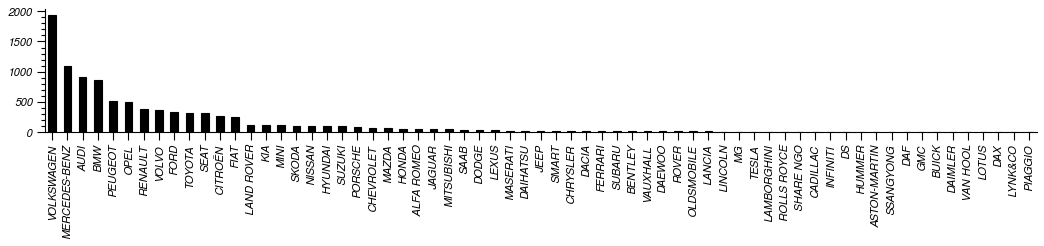

In [18]:
# histogram of occurence (prevalence) of classes
pd.Series(drz['target']).value_counts().plot(kind='bar', figsize=[16,2])
plt.gca().xaxis.set_tick_params(which='minor', bottom=False)
plt.show()


In [19]:
# function to plot exemplars

def plot_observations(observations, titles=None, margin=10, image_size=(128,85)):
    '''
    Displays images in one large figure.
    
    Note that the observations are one vector per observation as it is fed to the classifier with every pixel a feature.
    '''
    
    # number of tiles
    n_tiles = len(observations)
    
    if titles is None:
        titles = [str(i) for i in range(n_tiles)]
    
    # dimension of output row/columns
    nc = np.floor(np.sqrt(n_tiles)).astype(int) # largest in tile -> floor
    nr = np.ceil(n_tiles/nc).astype(int)
    # adjust 
    n_tiles_rect = nr*nc
    # empty figure
    im_rect = np.ones([image_size[1]*nr + margin*(nr+1), image_size[0]*nc + margin*(nc+1)])*observations.max()

    # fill rectangle
    title_coori = []
    title_coorj = []
    for ir in range(nr):
        for ic in range(nc):
            i = ir*nc + ic # tile index
            if i >= n_tiles:
                break
                
                
            # coordinates in rectangle
            offsetij = (ir*image_size[1] + margin*(ir+1), 
                        ic*image_size[0] + margin*(ic+1))
            coor_i = [b + offsetij[0] for b in [0, image_size[1]]]
            coor_j = [b + offsetij[1] for b in [0, image_size[0]]]
            # put image
            im_rect[
                coor_i[0]:coor_i[1],
                coor_j[0]:coor_j[1]
            ] = observations[i].reshape(image_size[1], image_size[0])
            title_coori += [coor_i[0]]
            # title_coorj += [(coor_j[1]-coor_j[0])/2 + coor_j[0]]
            title_coorj += [coor_j[0]]

    # prettify
    dpi = 96
    fig = plt.figure(figsize=[nc*image_size[0]/dpi*2, nr*image_size[1]/dpi*2], dpi=dpi)
    ax = fig.gca()
    ax.axis('off')
    # place
    ax.imshow(im_rect, cmap='Greys_r')

    # titles
    for y,x,t in zip(title_coori, title_coorj, titles):
        ax.text(x, y, t, ha='left', va='top')


In [20]:
# Plot observations 
if VERBOSE and not USE_HIGH_RES:
    plot_observations(np.array([drz['data'].var(axis=0)]), ['variance within images'], image_size=image_size)

# sel = drz['target'] == PREDICT_CLASS
# sel = drz['target'] == 'sedan'
# sel = drz['target'] == 'sedan'
# sel = drz['target'] == 'DAIMLERCHRYSLER AG'
auction_dates = df.reset_index()['index'].apply(lambda x:'-'.join(x.split('-')[0:-1])).values
sel = auction_dates == max(auction_dates)
# sel = auction_dates > np.unique(auction_dates)[-6]

if VERBOSE and not USE_HIGH_RES:
    plot_observations(drz['data'][sel], image_size=image_size, titles=list(df[sel].index))
display(df[sel].iloc[-1])

image_urls              [http://verkoop.domeinenrz.nl/ufc/static/17472...
brand                                                       MERCEDES-BENZ
model                                                            e300 cdi
model_specification                                                   NaN
color                                                                 NaN
age                                                                   NaT
body_type                                                             NaN
convertible                                                         False
number_of_doors                                                       NaN
length                                                                NaN
height                                                                NaN
width                                                                 NaN
wheelbase                                                             NaN
foreign_registration                  

In [21]:
# empty dict to store models
models = dict()

<a href="#clf_top" id='clf_model_1'><font size=+1><center>^^ TOP ^^</center></font></a>

---

# Model: Simple binary classifier

## Prepare input

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

model_name = 'binary classifier with gradient descent'

X, y = drz['data'], drz['target']
print(X.shape)
print(y.shape)

(9538, 174592)
(9538,)


## Fit

In [23]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

#test_size = 0.3
#i_split = round(n_obs * (1-0.3)) # index where to split
#shuffle_index = np.random.RandomState(seed=42).permutation(n_obs)
#assert shuffle_index[0] == 309 # sanity check
# actual split
#X_train, y_train = X[:i_split], y[:i_split]
#X_test, y_test = X[i_split:], y[i_split:]

# split train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

n_test = len(X_test)


(6676, 174592)
(2862, 174592)


## Binary classifier: Stochastic gradient descent

In [24]:
# class
predict_class = PREDICT_CLASS
y_binary, y_train_binary, y_test_binary = (y == predict_class), (y_train == predict_class), (y_test == predict_class)
# plt.hist(y_train_binary_astype('int'), bins=[-0.5,0.5,1.5])
# plt.hist(y_test_binary.astype('int'), bins=[-0.5,0.5,1.5])

In [25]:
# create classifier
clf = SGDClassifier(random_state=42, verbose=VERBOSE>1, fit_intercept=False)
models[model_name].update({'model':clf})

# fit
clf.fit(X_train, y_train_binary)
y_pred = clf.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})
models[model_name].update({'classes':[predict_class]})

# parameters
betas = [clf.intercept_[0], *clf.coef_[0]] # index 0 because of two classes
models[model_name].update({'betas':betas})

# scoring

# accuracy
models[model_name].update({'acc':clf.score(X,y_binary)})
models[model_name].update({'test acc':clf.score(X_test,y_test_binary)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='accuracy')
models[model_name].update({'cv acc':cv_results})
# f1
models[model_name].update({'f1':f1_score(y_binary, clf.predict(X))})
models[model_name].update({'test f1':f1_score(y_test_binary, y_pred)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='f1')
models[model_name].update({'cv f1':cv_results})

# sanity check to see if score is accuracy
y_train_pred = clf.predict(X_train)
assert sum(y_pred == y_test_binary) / n_test == clf.score(X_test,y_test_binary)
assert sum(y_pred == y_test_binary) / n_test == models[model_name]['test acc']

/home/tom/bin/satdatsci/Saturday-Datascience/results/binary_classifier_with_gradient_descent.png


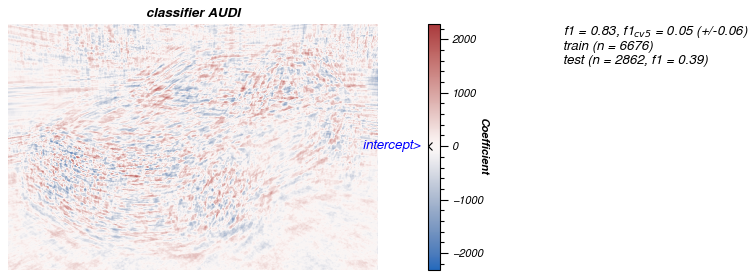

In [26]:
# plot classifier
plt.figure(figsize=[16,4])
plt.imshow(np.array(betas[1:]).reshape([image_size[1], image_size[0]]), cmap='vlag')
plt.axis('off')
plt.title('classifier {}'.format(predict_class))
cbar = plt.colorbar()
cbar.set_label('Coefficient', rotation=270)
cbar.ax.plot(0, models[model_name]['betas'][0], 'xb')
cbar.ax.text(0, models[model_name]['betas'][0], '  intercept>  ', style='italic', color='b', va='center', ha='right')
# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.5,xy[1], 'f1 = {:.2f}, f1$_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['f1'],
    models[model_name]['cv f1'].shape[0],
    np.mean(models[model_name]['cv f1']),
    np.std(models[model_name]['cv f1']),
) + '\n' +
         'train (n = {})'.format(y_train_binary.shape[0]) + '\n' +
         'test (n = {}, f1 = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test f1'],
         ), style='italic', va='top', ha='left')


# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if OPBOD:
    file_name = file_name.replace('.png', '-opbod.png')
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    

In [27]:
# Cross validation
# cross_validate(clf, X_test, y_test_binary, cv=8, scoring=['accuracy', 'balanced_accuracy', 'f1'], VERBOSE=3, n_jobs=4)

<a href="#clf_top" id='clf_model_2'><font size=+1><center>^^ TOP ^^</center></font></a>

---

# Model: random forest

## Prepare input

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_name = 'random forest'

X, y = drz['data'], drz['target']
print(X.shape)
print(y.shape)

(9538, 174592)
(9538,)


## Fit

In [29]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

#test_size = 0.3
#i_split = round(n_obs * (1-0.3)) # index where to split
#shuffle_index = np.random.RandomState(seed=42).permutation(n_obs)
#assert shuffle_index[0] == 309 # sanity check
# actual split
#X_train, y_train = X[:i_split], y[:i_split]
#X_test, y_test = X[i_split:], y[i_split:]

# split train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

n_test = len(X_test)


(6676, 174592)
(2862, 174592)


## Binary classifier: Random Forest Classifier

In [30]:
# create classifier
clf = RandomForestClassifier(random_state=42, verbose=VERBOSE>1)
models[model_name].update({'model':clf})

# fit
clf.fit(X_train, y_train_binary)
y_pred = clf.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})
models[model_name].update({'classes':[predict_class]})

# parameters
betas = [np.nan, clf.feature_importances_] # NaN, because rndforclf has no intercept
models[model_name].update({'betas':betas})

# scoring

# accuracy
models[model_name].update({'acc':clf.score(X,y_binary)})
models[model_name].update({'test acc':clf.score(X_test,y_test_binary)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='accuracy')
models[model_name].update({'cv acc':cv_results})
# f1
models[model_name].update({'f1':f1_score(y_binary, clf.predict(X))})
models[model_name].update({'test f1':f1_score(y_test_binary, y_pred)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='f1')
models[model_name].update({'cv f1':cv_results})

# sanity check to see if score is accuracy
y_train_pred = clf.predict(X_train)
assert sum(y_pred == y_test_binary) / n_test == clf.score(X_test,y_test_binary)
assert sum(y_pred == y_test_binary) / n_test == models[model_name]['test acc']
assert clf.n_features_in_ == X.shape[1]


/home/tom/bin/satdatsci/Saturday-Datascience/results/random_forest.png


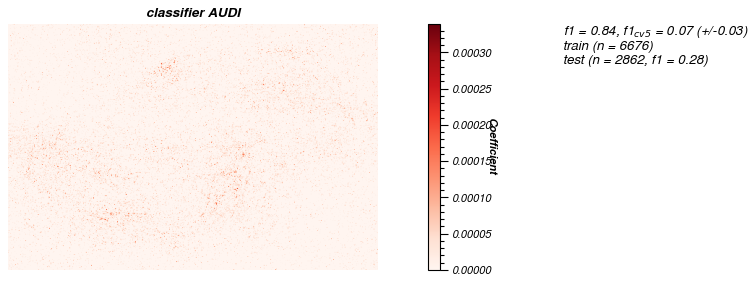

In [31]:
# plot classifier
plt.figure(figsize=[16,4])
plt.imshow(np.array(betas[1:]).reshape([image_size[1], image_size[0]]), cmap='Reds')
plt.axis('off')
plt.title('classifier {}'.format(predict_class))
cbar = plt.colorbar()
cbar.set_label('Coefficient', rotation=270)
# cbar.ax.plot(0, models[model_name]['betas'][0], 'xb')
# cbar.ax.text(0, models[model_name]['betas'][0], '  intercept>  ', style='italic', color='b', va='center', ha='right')
# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.5,xy[1], 'f1 = {:.2f}, f1$_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['f1'],
    models[model_name]['cv f1'].shape[0],
    np.mean(models[model_name]['cv f1']),
    np.std(models[model_name]['cv f1']),
) + '\n' +
         'train (n = {})'.format(y_train_binary.shape[0]) + '\n' +
         'test (n = {}, f1 = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test f1'],
         ), style='italic', va='top', ha='left')


# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if OPBOD:
    file_name = file_name.replace('.png', '-opbod.png')
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    

<a href="#clf_top" id='clf_model_3'><font size=+1><center>^^ TOP ^^</center></font></a>

---

# Model: multiclass 

## Prepare input

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone

encoding_labels = LabelEncoder()
drz['encoded_target'] = encoding_labels.fit_transform(drz['target'])

model_name = 'gradient descent multiclass'

X, y = drz['data'], drz['encoded_target']
print(X.shape)
print(y.shape)

(9538, 174592)
(9538,)


## Fit

In [33]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

#test_size = 0.3
#i_split = round(n_obs * (1-0.3)) # index where to split
#shuffle_index = np.random.RandomState(seed=42).permutation(n_obs)
#assert shuffle_index[0] == 309 # sanity check
# actual split
#X_train, y_train = X[:i_split], y[:i_split]
#X_test, y_test = X[i_split:], y[i_split:]

# split train/test set
clss,cnt = np.unique(y, return_counts=True)
sel = np.isin(y, clss[cnt > 1]) # drop classes with n_obs = 1
print('Drop', encoding_labels.inverse_transform(clss[cnt <= 1]))
X_train, X_test, y_train, y_test = train_test_split(X[sel],y[sel], test_size = 0.3, random_state=42, stratify=y[sel])
print(X_train.shape)
print(X_test.shape)

n_test = len(X_test)


Drop ['BUICK' 'DAIMLER' 'DAX' 'GMC' 'LOTUS' 'LYNK&CO' 'PIAGGIO' 'VAN HOOL']
(6671, 174592)
(2859, 174592)


In [34]:
# create classifier: Copy from earlier model
clf = clone(models['binary classifier with gradient descent']['model'])

models[model_name].update({'model':clf})

# fit
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})
models[model_name].update({'classes':encoding_labels.classes_})

# parameters
betas = np.concatenate([np.matrix(clf.intercept_).T, clf.coef_], axis=1)
models[model_name].update({'betas':betas})

# scoring

# accuracy
models[model_name].update({'acc':clf.score(X,y)})
models[model_name].update({'test acc':clf.score(X_test,y_test)})
cv_results = cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy')
models[model_name].update({'cv acc':cv_results})
# f1
models[model_name].update({'f1':f1_score(y, clf.predict(X), average=None)})
models[model_name].update({'test f1':f1_score(y_test, y_pred, average=None)})
cv_results = cross_val_score(clf, X_test, y_test, cv=5, scoring='f1_micro') # micro takes into account class imbalance
models[model_name].update({'cv f1':cv_results})

# sanity check to see if score is accuracy
assert sum(y_pred == y_test) / n_test == clf.score(X_test,y_test)
assert sum(y_pred == y_test) / n_test == models[model_name]['test acc']
assert f1_score(y_test, y_pred, average=None).mean() == f1_score(y_test, y_pred, average='macro')

/home/tom/bin/py310-satdatsci/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tom/bin/py310-satdatsci/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


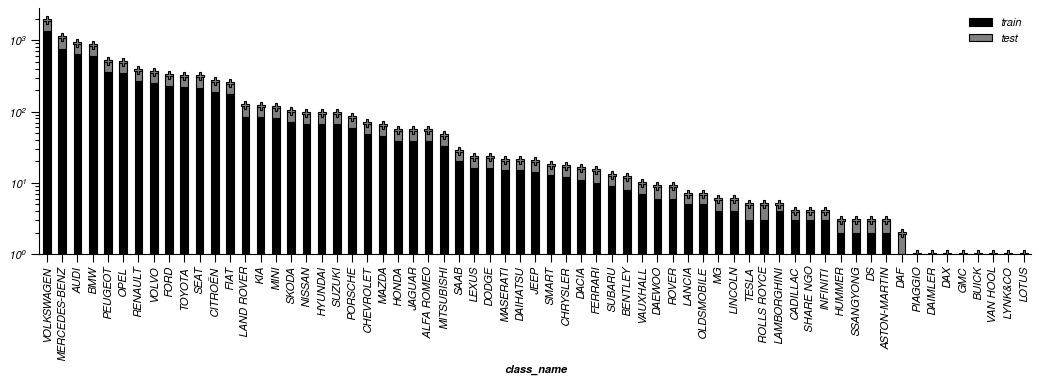

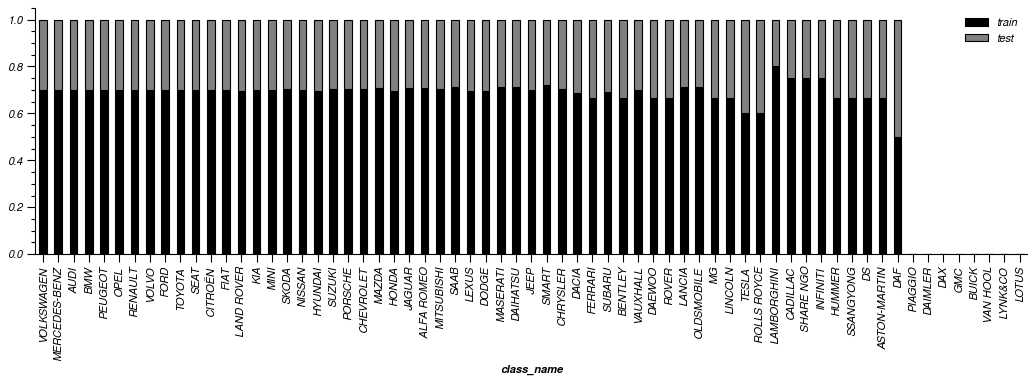

In [35]:
hist_ = pd.DataFrame(columns=['orig','train','test','class_name'])
hist_.class_name=models[model_name]['classes']
clss,cnt = np.unique(y, return_counts=True)
hist_.loc[clss,'orig'] = cnt
clss,cnt = np.unique(y_train, return_counts=True)
hist_.loc[clss,'train'] = cnt
clss,cnt = np.unique(y_test, return_counts=True)
hist_.loc[clss,'test'] = cnt
hist_.sort_values(by='orig', ascending=False, inplace=True)

hist_.set_index('class_name').loc[:,['train', 'test']].plot(kind='bar', stacked=True, figsize=[16,4])
plt.plot(hist_.set_index('class_name').loc[:,['orig']],'P')
plt.yscale('log')
plt.gca().xaxis.set_tick_params(which='minor', bottom=False)
hist_.set_index('class_name').loc[:,['train', 'test']].div(hist_.set_index('class_name').orig, axis=0)\
.plot(kind='bar', stacked=True, figsize=[16,4])
plt.gca().xaxis.set_tick_params(which='minor', bottom=False)



In [ ]:
# betas = [clf.intercept_[0], *clf.coef_[0]] 

plot_observations(clf.coef_, models[model_name]['classes'][clf.classes_], image_size=image_size)
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if OPBOD:
    file_name = file_name.replace('.png', '-opbod.png')
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    

plot_observations(np.array([clf.coef_.var(axis=0)]), 'variance within coefficients', image_size=image_size)
# Save
file_name = f"{RESULTS_DIR}/variance-within-{model_name.replace(' ','_')}.png"
if OPBOD:
    file_name = file_name.replace('.png', '-opbod.png')
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    

<a href="#clf_top" id='clf_performance'><font size=+1><center>^^ TOP ^^</center></font></a>

---

# Model performances

/home/tom/bin/satdatsci/Saturday-Datascience/results/model-performance-classification.png


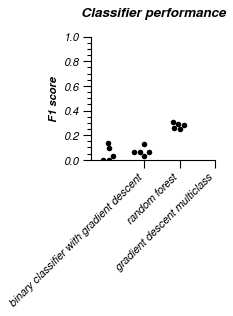

In [37]:
# plot f1

# counter for x-offset
c=0

# figure
fig = plt.figure(figsize=[2,2])
ax = fig.gca()
xs = ys = np.array(None, dtype='float')

# loop over all models
for name,res in models.items():

    c+=1 # x-offset

    score = res['cv f1']
    
    # add scores and offset to vectors
    ys = np.append(ys,score)
    xs = np.append(xs,np.ones_like(score) * c)

# actual plotting
sns.swarmplot(x=xs, y=ys, ax=ax)
#ax.bar(range(1,len(models)+1), [res['f1'] for res in models.values()], width=0.8, fc='none')
# prettify
ax.set_xticks(range(1,len(models)+1))
ax.set_xticklabels(models.keys(), rotation=45, va='top', ha='right', style='italic')
ax.set_ylim(bottom=0, top=1)
ax.set_title('Classifier performance\n', style='italic')
ax.set_ylabel('F1 score', style='italic')
ax.xaxis.set_tick_params(which='minor', bottom=False)

# save
file_name = f'{RESULTS_DIR}/model-performance-classification.png'
if OPBOD:
    file_name = file_name.replace('.png', '-opbod.png')
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    

<a href="#clf_top" id='clf_performance_confmtx'><font size=+1><center>^^ TOP ^^</center></font></a>

### Confusion matrix
https://en.wikipedia.org/wiki/Precision_and_recall

In [38]:
# plot confusion matrix
def plot_confusion_matrix(mtx, class_name):
    '''
    Present the confusion matrix as an image
    '''
    
    # results
    n_tp = mtx[1,1] # hit
    n_tn = mtx[0,0] # corr reject
    n_fp = mtx[0,1] # false alarm, Type I err
    n_fn = mtx[1,0] # miss, Type II err
    n_cp = sum(mtx[1,:]) # condition pos
    n_cn = sum(mtx[0,:]) # condition neg
    n_pp = sum(mtx[:,1]) # prediction pos
    n_pn = sum(mtx[:,0]) # prediction negative
    n_corr = n_tp + n_tn
    n_wrong = n_fp + n_fn

    f = plt.figure(figsize=[4,4])
    ax = f.gca()
    # rotate axis to get true pos upper left
    ax.set_xlim(left=1.5, right=-0.5)
    ax.set_ylim(top=1.5, bottom=-0.5)
    # prettify
    ax.set_xlabel('Predicted', style='italic')
    ax.set_ylabel('Real', style='italic')
    ax.set_title('Confusion matrix\n(n={})'.format(sum(mtx.ravel())), style='italic')
    ax.set_xticks(ticks=[0,1], labels=['not a ' + class_name, class_name])
    ax.set_yticks(ticks=[0,1], labels=['not a ' + class_name, class_name])
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.yaxis.set_tick_params(which='minor', left=False)

    # plot image
    im = ax.imshow(mtx, cmap='Blues_r')
    
    # add values
    for ir, pred in enumerate(mtx):
        for ic, n in enumerate(pred):
            ax.text(ic, ir, str(n), va='center', ha='center', weight='bold')

    # add summed values
    ax.text(-0.5, -0.5, n_corr, va='top', ha='left', style='italic')
    ax.text(-0.5, 1.5, n_wrong, va='bottom', ha='left', style='italic')
    ax.text(0, -0.5, n_pn, va='bottom', ha='center', style='italic')
    ax.text(1, -0.5, n_pp, va='bottom', ha='center', style='italic')
    ax.text(-0.5, 0, n_cn, va='center', ha='right', style='italic')
    ax.text(-0.5, 1, n_cp, va='center', ha='right', style='italic')

    # other stats
    recall = n_tp/n_cp # true pos rate
    specificity = n_tn/n_cn # true neg rate
    F1 = 2*(recall * specificity / (recall + specificity))
    accu = n_corr / (n_corr + n_wrong)
    bacc = (recall + specificity)/2
    prec = n_tp/n_pp

    
    xy=[ax.get_xlim()[1], ax.get_ylim()[1]]
    ax.text(xy[0]*1.2,xy[1],'\n'.join([
        'F1: {:.3f}', 
        'accuracy:{:.1%}',
        'balanced acc.: {:.1%}',
        'precision: {:.1%}',
        'recall: {:.1%}',
        'specificity: {:.1%}'
    ]).format(F1, accu, bacc, prec, recall, specificity),
             va='top', ha='left', style='italic'
            )

In [39]:
# Stats
test_fraction = len(y_test)/models['gradient descent multiclass']['n']
n_classes = models['gradient descent multiclass']['classes'].shape[0]

# Class occurrence in whole dataset
count_dataset, bins = np.histogram(y, bins=range(0, n_classes+1))
class_order = bins[np.argsort(count_dataset)[::-1]]
occurence = count_dataset * test_fraction # before test-split

# class names
class_names = models['gradient descent multiclass']['classes']
class_names_brief = [b[0]+'.' for b in class_names]


print(f'nr of classes: {n_classes}\ntest fraction: {test_fraction:.1%}\nmost occuring: {class_names_brief[class_order[0]]} {class_names[class_order[0]]}')

nr of classes: 65
test fraction: 30.0%
most occuring: V. VOLKSWAGEN


/tmp/ipykernel_415011/2711084619.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, va='top', ha='right', style='italic')
/tmp/ipykernel_415011/2711084619.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, va='top', ha='right', style='italic')
/tmp/ipykernel_415011/2711084619.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, va='top', ha='right', style='italic')
/tmp/ipykernel_415011/2711084619.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, va='top', ha='right', style='italic')
/tmp/ipykernel_415011/271108

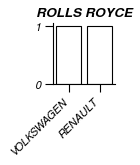

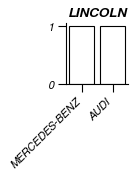

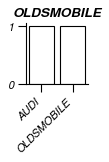

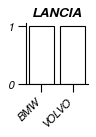

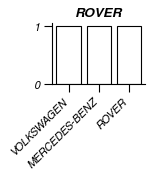

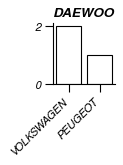

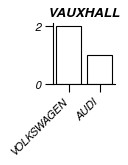

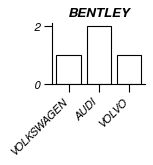

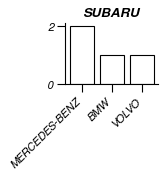

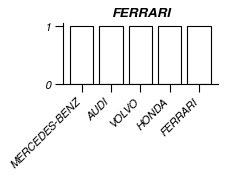

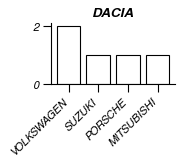

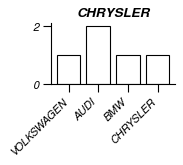

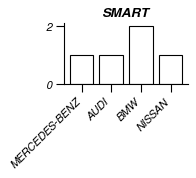

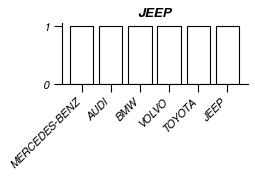

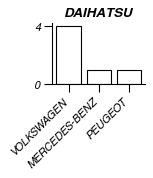

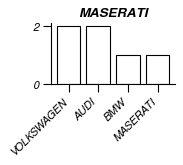

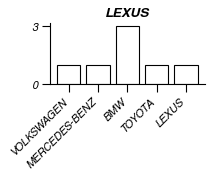

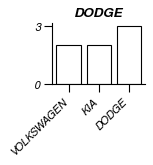

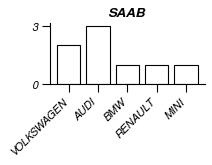

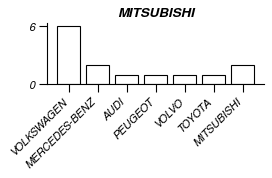

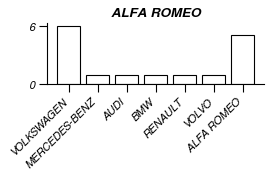

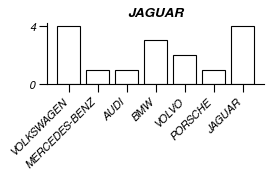

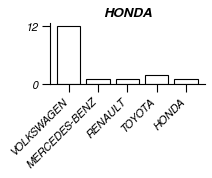

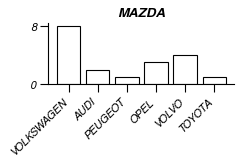

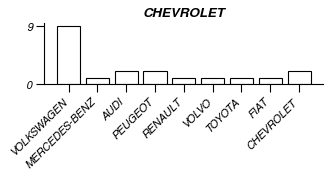

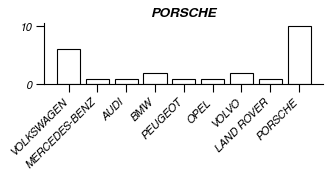

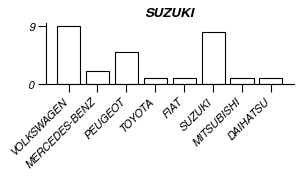

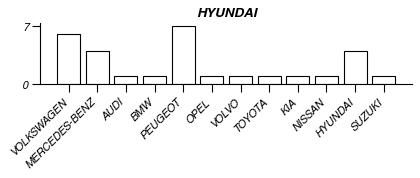

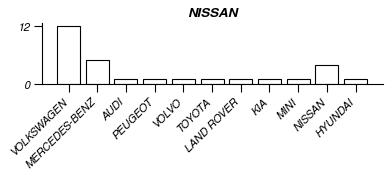

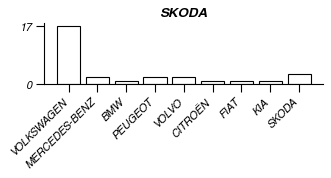

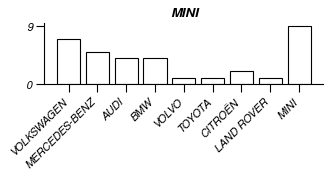

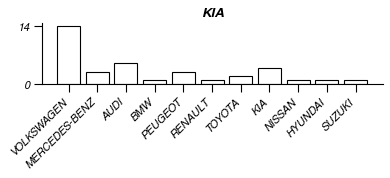

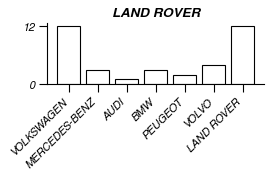

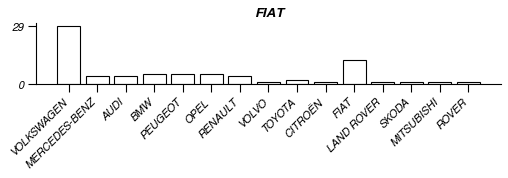

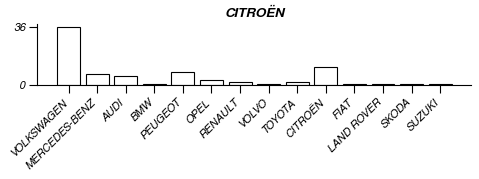

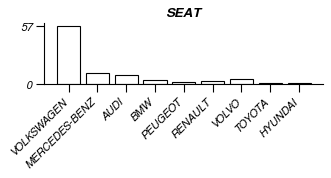

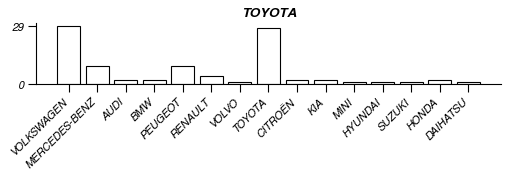

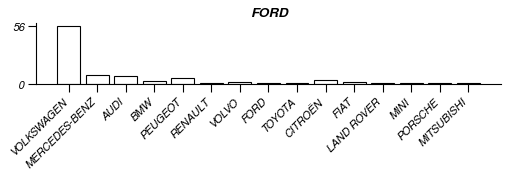

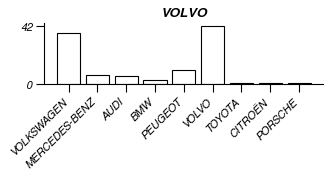

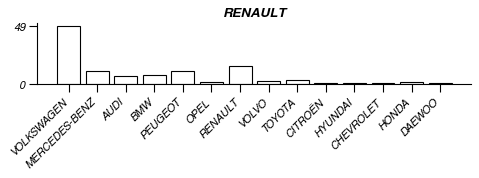

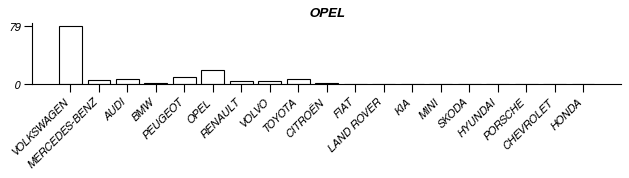

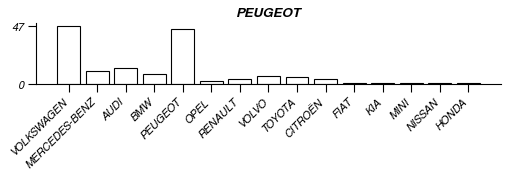

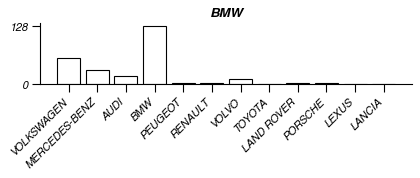

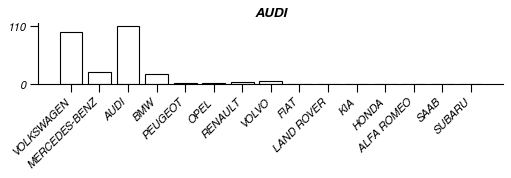

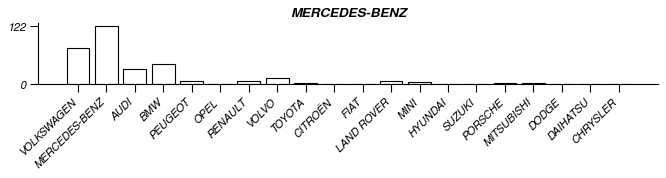

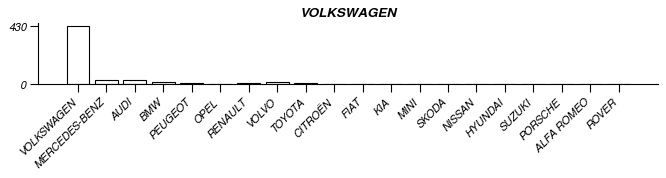

In [40]:
# Confusion matrix
H, xegdes, yedges = np.histogram2d(
    y_test, y_pred,
    bins=bins,
    density=False)

# nr of predictions
assert H.sum().sum() == y_test.shape

# assert all(c > 0), np.where(c==0)

for class_idx in class_order[::-1]:
    x = class_names[class_order]
    h = H[class_idx][class_order]
    x=x[h>0]
    h=h[h>0]
    if len(h)<2: continue;
    f = plt.figure(figsize=(0.5*len(h),1))
    ax = f.gca()
    ax.bar(x=x, height=h, facecolor='None', edgecolor='k')
    ax.set_title(class_names[class_idx])
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.yaxis.set_tick_params(which='minor', left=False, )
    ax.yaxis.set_ticks([0, int(max(h))])
    ax.set_xticklabels(x, rotation=45, va='top', ha='right', style='italic')


In [41]:
# calculate predictions
n_correct = np.diagonal(H)
frc_correct = n_correct/H.sum(axis=1)
n_wrong = H.sum(axis=1) -  n_correct
frc_wrong_re_tot = n_wrong/occurence
frc_correct_re_tot = n_correct/occurence

# example
#example_class = class_order[0]
#example_class = np.where(class_names=='VOLVO')[0][0]
example_class = np.where(class_names==predict_class)[0][0]
example_name = class_names[example_class]
n_example_target = H[example_class,:]
n_example_predicted = H[:,example_class]

print(f'Example class: {example_name}')

Example class: AUDI


/tmp/ipykernel_415011/4140864676.py:3: RuntimeWarning: invalid value encountered in divide
  frc_correct = n_correct/H.sum(axis=1)


Text(0, 0.5, 'Fraction predicted correct')

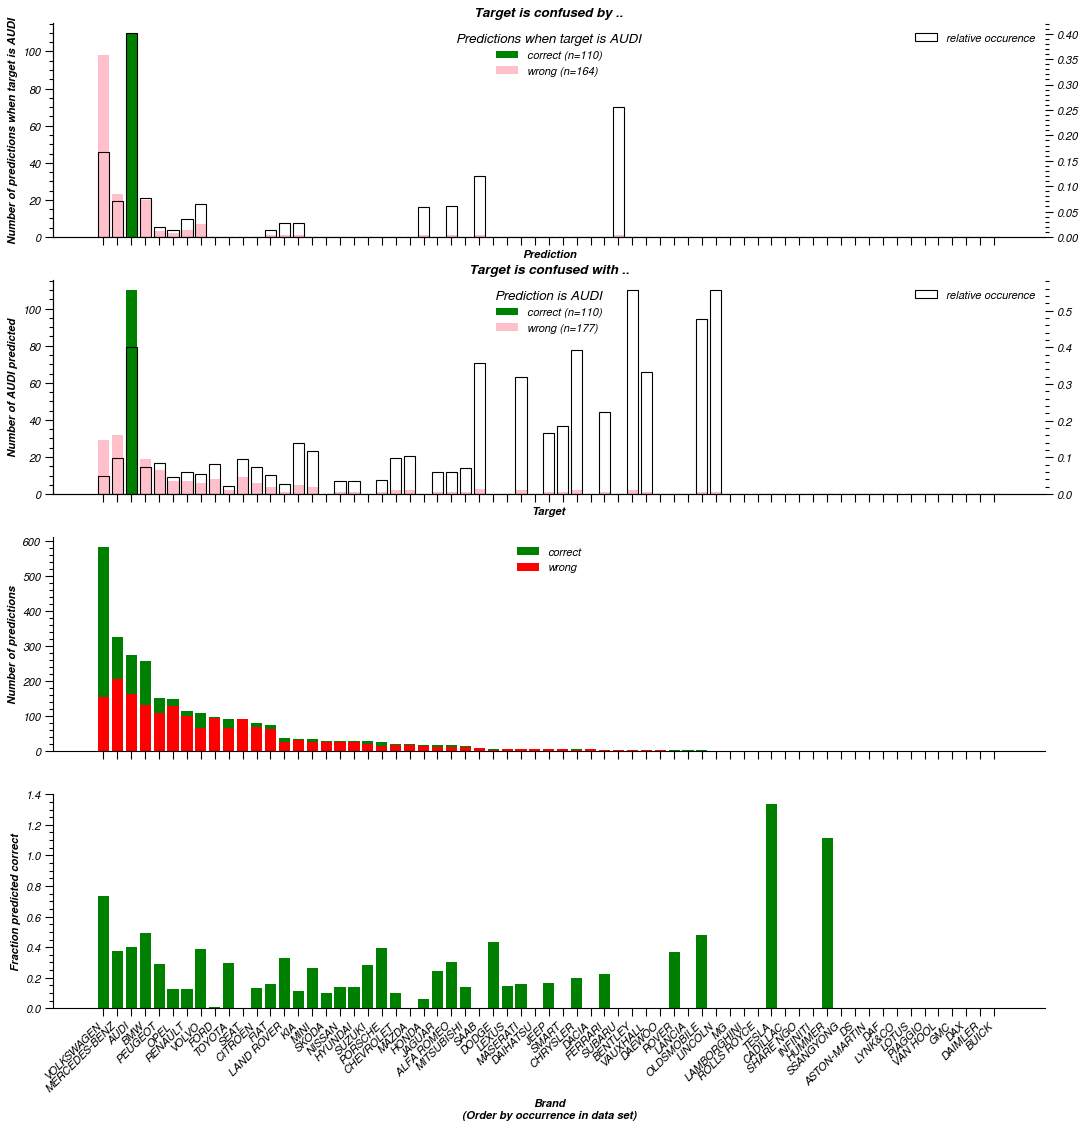

In [42]:
# Prepare figure
fig, axs = plt.subplots(
    figsize=(16, 4*4),
    nrows=4, ncols=1,
    sharex=True,
)
for ax in axs:
    ax.set_xticks(range(0, n_classes))
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.set_xticklabels([b[0] for b in class_names[class_order]], rotation=0, va='top', ha='right', style='italic')
axs[-1].set_xticklabels(class_names[class_order], rotation=45, va='top', ha='right', style='italic')
axs[-1].set_xlabel('Brand\n(Order by occurrence in data set)')

# Plot example histogram 1
ax = axs[0]
ax.set_title('Target is confused by ..')
ax.set_xlabel('Prediction')
ax.set_ylabel(f'Number of predictions when target is {example_name}')
secax = ax.twinx()

correct = n_example_target[class_order] * (class_order == example_class)
wrong = n_example_target[class_order] * (1-(class_order == example_class))
frc = n_example_target[class_order]/occurence[class_order]

ax.bar(range(0, n_classes), correct,
      edgecolor='None', facecolor='green', label=f'correct (n={sum(correct):.0f})')
ax.bar(range(0, n_classes), wrong,
      edgecolor='None', facecolor='pink', label=f'wrong (n={sum(wrong):.0f})')
secax.bar(range(0, n_classes), height=frc, 
          edgecolor='k', facecolor='none', label='relative occurence')

ax.legend(loc='upper center', title=f'Predictions when target is {example_name}')
secax.legend(loc='upper right')

# Plot example histogram 2
ax = axs[1]
ax.set_title('Target is confused with ..')
ax.set_xlabel('Target')
ax.set_ylabel(f'Number of {example_name} predicted')
secax = ax.twinx()

correct = n_example_predicted[class_order] * (class_order == example_class)
wrong = n_example_predicted[class_order] * (1-(class_order == example_class))
frc = n_example_predicted[class_order]/occurence[class_order]

ax.bar(range(0, n_classes), correct,
      edgecolor='None', facecolor='green', label=f'correct (n={sum(correct):.0f})')
ax.bar(range(0, n_classes), wrong,
      edgecolor='None', facecolor='pink', label=f'wrong (n={sum(wrong):.0f})')
secax.bar(range(0, n_classes), height=frc, 
          edgecolor='k', facecolor='none', label='relative occurence')

ax.legend(loc='upper center', title=f'Prediction is {example_name}')
secax.legend(loc='upper right')

# Absolute values of all
ax = axs[2]
ax.set_ylabel('Number of predictions')
#ax.set_yscale('log')

ax.bar(range(0, n_classes), occurence[class_order],
       edgecolor='None', facecolor='green', label='correct')
ax.bar(range(0, n_classes), n_wrong[class_order],
       edgecolor='None', facecolor='red', label='wrong')

ax.legend(loc='upper center')

# Normalized 
ax = axs[3]
#ax.set_ylim(top=1.0)

ax.bar(range(0, n_classes), frc_correct_re_tot[class_order],
      edgecolor='None', facecolor='green')
ax.set_ylabel('Fraction predicted correct')


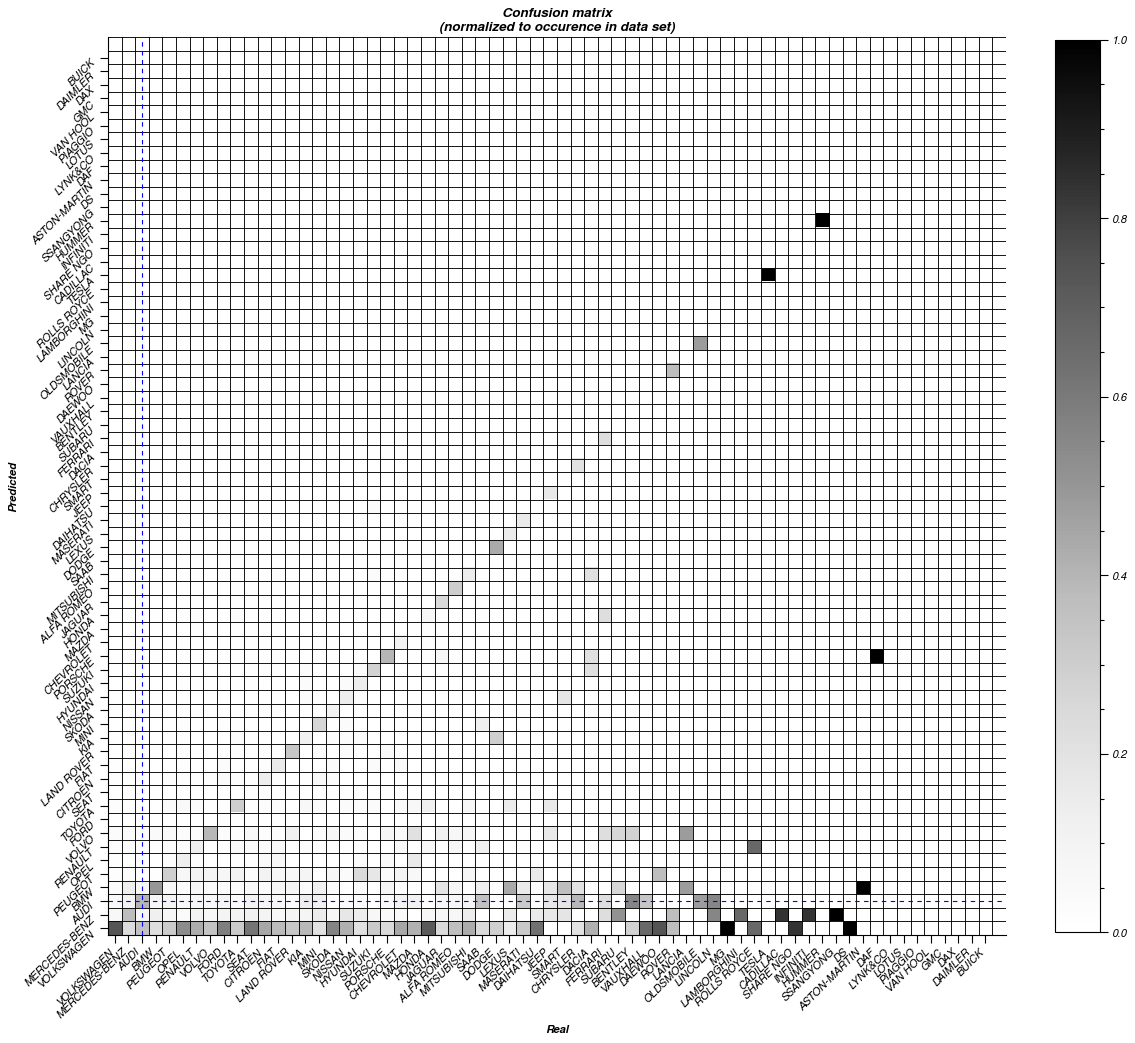

In [43]:
# Image
img = H.T.copy()
# Normalize and remove diagonal
img /= count_dataset * test_fraction # wrt total in data set. Test size is 0.3
#img *= (1-np.eye(len(H)))
# sort axis
img = img[:, class_order] 
img = img[class_order, :]

# Plot matrix
fig = plt.figure(figsize=(16,16))
ax = fig.gca()
imgplot = ax.imshow(img, vmax=1, vmin=0,
                    cmap='Greys',
                    origin='lower')
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.yaxis.set_tick_params(which='minor', bottom=False)
ax.set_xticks(range(0, n_classes))
ax.set_xticklabels(class_names[class_order], rotation=45, va='top', ha='right', style='italic')
ax.set_yticks(range(0, n_classes))
ax.set_yticklabels(class_names[class_order], rotation=45, va='top', ha='right', style='italic')
ax.set_xticks(np.arange(-0.5, n_classes+1, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n_classes+1, 1), minor=True)
ax.grid(which='minor')
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
ax.set_title('Confusion matrix\n(normalized to occurence in data set)')
ax.axvline(np.where(class_order==example_class), color='b', linestyle='--')
ax.axhline(np.where(class_order==example_class), color='b', linestyle='--')

# colorbar
cbar = fig.colorbar(imgplot, fraction=.045, aspect=20)

In [ ]:
for model_name, model in models.items():
    clf = model['model']
    if model_name == 'gradient descent multiclass':
        y = drz['encoded_target']
    else:
        y = drz['target']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
    y_pred = clf.predict(X_test)
    
    for predict_class_index, predict_class in enumerate(model['classes']):
        if model_name == 'gradient descent multiclass':
            y_pred_binary = y_pred == predict_class_index
            y_test_binary = y_test == predict_class_index
        else:
            y_test_binary = y_test == predict_class
            y_pred_binary = y_pred
    
        conf_mtx = confusion_matrix(y_test_binary, y_pred_binary)
        if not (conf_mtx.shape == (2,2)):
            # not possible to plot conf mtx
            print(conf_mtx)
            continue
        else:
            display(pd.DataFrame(
                conf_mtx, 
                index=pd.Index(['real neg','real pos'], name=predict_class), 
                columns=['pred neg','pred pos']
            ))
        # True negatives:  [0,0]
        # False negatives: [1,0]
        # True positives:  [1,1] 
        # False positives: [0,1].
        assert sum(conf_mtx[:,1]) == sum(y_pred_binary)
        assert sum(conf_mtx[1,:]) == sum(y_test_binary)
        assert conf_mtx[0,0] == sum(~y_pred_binary & ~y_test_binary) # correct negative

        # actual plotting
        plot_confusion_matrix(conf_mtx, predict_class)

        # save
        if not (model_name == 'gradient descent multiclass'):
            pass
        elif predict_class == models['binary classifier with gradient descent']['classes'][0]:
            pass
        else:
            # skip saving
            plt.close()
            continue
        # Save
        file_name = f"{RESULTS_DIR}/confusion-matrix-{model_name.replace(' ','_')}.png"
        if OPBOD:
            file_name = file_name.replace('.png', '-opbod.png')
        if True | do_save(file_name): # always save
            print(file_name)
            with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
                plt.savefig(file_name, bbox_inches='tight', transparent=False)
            plt.show()
        else:
            plt.show()
            print(f'Skip. {file_name} exists or saving is disabled in settings.')  

In [ ]:
# plot classification errors
for model_name, model in models.items():
    clf = model['model']
    if model_name == 'gradient descent multiclass':
        y = drz['encoded_target']
    else:
        y = drz['target']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
    y_pred = clf.predict(X_test)

    if model_name == 'gradient descent multiclass':
        predict_class = models['binary classifier with gradient descent']['classes'][0]
        predict_class_index = np.where(model['classes'] == predict_class)[0]
        y_test_binary = y_test == predict_class_index
        y_pred_binary = y_pred == predict_class_index
    else:
        y_test_binary = y_test == model['classes'][0]
        y_pred_binary = y_pred


    tp_test = y_pred_binary & y_test_binary
    fp_test = y_pred_binary & ~y_test_binary
    fn_test = ~y_pred_binary & y_test_binary

    if any(tp_test):
        plot_observations(X_test[tp_test], titles=y_test[tp_test], image_size=image_size)
        plt.title('true positive\n' + model_name)

    if any(fp_test):
        plot_observations(X_test[fp_test], titles=y_test[fp_test], image_size=image_size)
        plt.title('false positive\n' + model_name)

    if any(fn_test):
        plot_observations(X_test[fn_test], titles=y_test[fn_test], image_size=image_size)
        plt.title('false negative\n' + model_name)


<a href="#clf_top" id='clf_performance_roc'><font size=+1><center>^^ TOP ^^</center></font></a>

### ROC [c]urve

In [46]:
# plot ROC curve
def plot_roc_curve(fpr, fnr, auc):
    '''
    Plot ROC curve. False positive (fpr) and False negative(fnr) rates are already calculated, so is area under the ROC curve (auc).
    '''
    
    
    plt.figure(figsize=[8,8])
    plt.plot([0,1], [0,1], '--k')
    plt.plot(fpr, fnr, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(ticks=np.linspace(0,1,3))
    plt.yticks(ticks=np.linspace(0,1,3))
    plt.xlabel('False positive rate', style='italic')
    plt.ylabel('True positive rate', style='italic')
    plt.title('ROC curve', style='italic')


    # stats
    xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
    plt.text(xy[0]*1.05,xy[1],'\n'.join([
        'AUC test set: {:.3f}', 
    ]).format(auc),
             va='top', ha='left', style='italic'
            )



binary classifier with gradient descent
random forest


/home/tom/bin/py310-satdatsci/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
IOStream.flush timed out


gradient descent multiclass
/home/tom/bin/satdatsci/Saturday-Datascience/results/ROC-curves.png


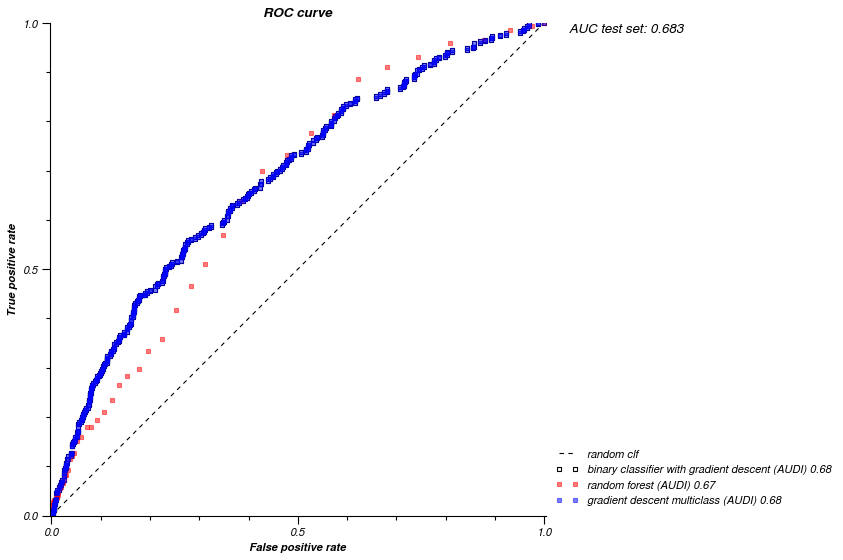

In [47]:
# plot ROC

# assemble results
fprs, fnrs, aucs, clss = [[],[],[],[]]
for model_name, model in models.items():
    print(model_name)
    clf = model['model']
    if model_name == 'gradient descent multiclass':
        y = drz['encoded_target']
    else:
        y = drz['target']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
    y_pred = clf.predict(X_test)
   
    if model_name == 'gradient descent multiclass':
        predict_class = models['binary classifier with gradient descent']['classes'][0]
        predict_class_index = np.where(model['classes'] == predict_class)[0][0]
        y_pred_binary = y_pred == predict_class_index
        y_test_binary = y_test == predict_class_index

    else:
        predict_class = model['classes'][0]
        y_pred_binary = y_pred
        y_test_binary = y_test == predict_class
        

    # Scores at all thresholds. 'cross_val_score' uses theshold 0
    if (model_name == 'binary classifier with gradient descent') | (model_name == 'gradient descent multiclass'):
        clf_scores = cross_val_predict(clf, X_test, y_test_binary, cv=8, method="decision_function", n_jobs=4)
    else:
        clf_scores = cross_val_predict(clf, X_test, y_test_binary, cv=8, method="predict_proba", n_jobs=4)[:,1]

    fpr, fnr, thresholds = roc_curve(y_test_binary, clf_scores)
    auc = roc_auc_score(y_test_binary, clf_scores)
    fprs += [fpr]
    fnrs += [fnr]
    aucs += [auc]
    clss += [predict_class]

# first creates a plot
plot_roc_curve(fprs[0], fnrs[0], aucs[0])
# add to plot
for fpr, fnr, auc, clr in zip(fprs[1:], fnrs[1:], aucs[1:], list('rb')):
    plt.plot(fpr, fnr, marker='s', linestyle='None', ms=4, alpha=0.5, mec=clr, mfc=clr)
# legend
labels = ['{} ({}) {:.2f}'.format(m, c, a) for m,c,a in zip(models, clss, aucs)]
plt.legend(['random clf'] + labels, loc='lower left', bbox_to_anchor=[1, 0])


# save
file_name = f'{RESULTS_DIR}/ROC-curves.png'
if OPBOD:
    file_name = file_name.replace('.png', '-opbod.png')
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')  

In [ ]:
assert False, 'Stop running. Below is sandboxing.'

openML has the following structure: 

```
from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784')
iris = fetch_openml('iris')

# choose dataset
openml_dataset = iris
openml_dataset.keys()



dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])
```
- - - 
The dictonary has the following keys

```
for k in openml_dataset:
    print(k, type(openml_dataset[k]))



data <class 'numpy.ndarray'>
target <class 'numpy.ndarray'>
feature_names <class 'list'>
DESCR <class 'str'>
details <class 'dict'>
categories <class 'dict'>
url <class 'str'>
```
- - - 
The fields contain the following
```
# create table
head = ['field', 'type', 'length']
width = [32, 32, 8]
pat = ['{{:>{}s}} | {{:{}s}} | {{:>{}s}}'.format(*width),
       '{{:>{}s}}-+-{{:{}s}}-+-{{:<{}s}}'.format(*width),
       '{{:>{}s}} | {{:{}s}} | {{:{}.0f}}'.format(*width),
      ]
sep = pat[1].format(''.join(['-']*width[0]), ''.join(['-']*width[1]), ''.join(['-']*width[2]))


# header
print(openml_dataset['details']['id'], openml_dataset['details']['name'], openml_dataset['details']['version'], openml_dataset['details']['original_data_url'], )
print(pat[0].format(*head))
print(sep)
# values
for k in openml_dataset:
    print(pat[2].format(k, str(type(openml_dataset[k])), len(openml_dataset[k])))

# deeper dict
k = 'details'
print(sep)
print(pat[0].format('{}[field]'.format(k), 'type', 'length'))
print(sep)
for kk in openml_dataset[k]:
    print(pat[2].format(kk, str(type(openml_dataset[k][kk])), len(openml_dataset[k][kk])))



61 iris 1 https://archive.ics.uci.edu/ml/datasets/Iris
                           field | type                             |   length
---------------------------------+----------------------------------+---------
                            data | <class 'numpy.ndarray'>          |      150
                          target | <class 'numpy.ndarray'>          |      150
                   feature_names | <class 'list'>                   |        4
                           DESCR | <class 'str'>                    |      932
                         details | <class 'dict'>                   |       19
                      categories | <class 'dict'>                   |        0
                             url | <class 'str'>                    |       27
---------------------------------+----------------------------------+---------
                  details[field] | type                             |   length
---------------------------------+----------------------------------+---------
                              id | <class 'str'>                    |        2
                            name | <class 'str'>                    |        4
                         version | <class 'str'>                    |        1
                          format | <class 'str'>                    |        4
                         creator | <class 'str'>                    |       11
                 collection_date | <class 'str'>                    |        4
                     upload_date | <class 'str'>                    |       19
                         licence | <class 'str'>                    |        6
                             url | <class 'str'>                    |       52
                         file_id | <class 'str'>                    |        2
        default_target_attribute | <class 'str'>                    |        5
                   version_label | <class 'str'>                    |        1
                             tag | <class 'list'>                   |       11
                      visibility | <class 'str'>                    |        6
               original_data_url | <class 'str'>                    |       44
                       paper_url | <class 'str'>                    |       63
                          status | <class 'str'>                    |        6
                 processing_date | <class 'str'>                    |       19
                    md5_checksum | <class 'str'>                    |       32
```
- - -
Size of _data_ and _target_ are
```
print(openml_dataset['data'].shape)
print(openml_dataset['target'].shape)



(150, 4)
(150,)
```

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
iris = fetch_openml('iris')

In [ ]:
openml_dataset = drz
openml_dataset.keys()

In [ ]:
iris['categories']

In [ ]:
# create table
head = ['field', 'type', 'length']
width = [32, 32, 8]
pat = ['{{:>{}s}} | {{:{}s}} | {{:>{}s}}'.format(*width),
       '{{:>{}s}}-+-{{:{}s}}-+-{{:<{}s}}'.format(*width),
       '{{:>{}s}} | {{:{}s}} | {{:{}.0f}}'.format(*width),
      ]
sep = pat[1].format(''.join(['-']*width[0]), ''.join(['-']*width[1]), ''.join(['-']*width[2]))


# header
print(openml_dataset['details']['id'], openml_dataset['details']['name'], openml_dataset['details']['version'], openml_dataset['details']['original_data_url'], )
print(pat[0].format(*head))
print(sep)
# values
for k in openml_dataset:
    print(pat[2].format(k, str(type(openml_dataset[k])), len(openml_dataset[k])))

# deeper dict
k = 'details'
print(sep)
print(pat[0].format('{}[field]'.format(k), 'type', 'length'))
print(sep)
for kk in openml_dataset[k]:
    print(pat[2].format(kk, str(type(openml_dataset[k][kk])), len(openml_dataset[k][kk])))


In [ ]:
print(openml_dataset['data'].shape)
print(openml_dataset['target'].shape)


In [ ]:
openml_dataset['details'].keys()

In [ ]:
mnist['feature_names']

In [ ]:
def im2magn(im):
    fft = np.fft.fft2(im)
    magnitude_spectrum = 20*np.log(np.abs(fft))
    mm = [np.unique(magnitude_spectrum[~np.isinf(magnitude_spectrum)])[i] for i in [0,-1]]
    norm = mm[0] + magnitude_spectrum/mm[1]-mm[0]

    norm[norm<0] = 0
    norm[norm>1] = 1
    
    return norm

In [ ]:
fn1 = '/home/tom/data/satdatsci-images/2021/2021-16-8083-00.jpg'
fn2 = '/home/tom/data/satdatsci-images/2021/2021-16-8082-00.jpg'

In [ ]:
im = Image.open(fn2)
im = im.convert('L')
im

In [ ]:
# im=np.reshape(drz['data'][-1],(85,-1))

fft = np.fft.fft2(im)
real = np.real(fft)
real[0,0] =0
imag = np.imag(fft)
fshift = fft.copy()
fshift = np.fft.fftshift(fshift)
#fshift = np.fft.ifftshift(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))
mm = [np.unique(magnitude_spectrum[~np.isinf(magnitude_spectrum)])[i] for i in [0,-1]]
norm = mm[0] + magnitude_spectrum/mm[1]-mm[0]

norm[norm<0] = 0
norm[norm>1] = 1

In [ ]:
#plt.imshow(np.real(fft))
#plt.imshow(np.real(real))
plt.imshow(norm)

In [ ]:
[np.unique(np.ravel(magnitude_spectrum))[i] for i in [0,1,-2,-1]]

In [ ]:
norm.max()


In [ ]:
plt.imshow(np.real(np.fft.ifft2(fft))*-1)

In [ ]:
plt.imshow(np.real(np.fft.ifft2(real))*-1)